In [1]:
import pandas as pd
import numpy as np

In [2]:
from database.database_parser import create_connection
from database.database_parser import select_curr_solution

test_connection = create_connection('../database/abacus_database.db')

In [3]:
from database.database_parser import select_price_data

def generate_volatility(params, data):
    n_observations = len(data)
    initial_squared_vol_estimate = (params[0]
                                        + params[1] * (data[0] ** 2)
                                        + params[3] * (data[0] ** 2) * np.where(data[0] < 0, 1, 0)
                                        + params[2] * (data[0] ** 2))
    current_squared_vol_estimate = initial_squared_vol_estimate

    for i in range(0, n_observations):
        current_squared_vol_estimate = (params[0] + params[1] * (data[i - 1] ** 2)
                                            + params[3] * (data[i - 1] ** 2) * np.where(data[i - 1] < 0, 1, 0)
                                            + params[2] * current_squared_vol_estimate)

    return np.sqrt(current_squared_vol_estimate)

def get_volatility(asset: str):
    opt_sol = select_curr_solution(test_connection, asset)
    adj_close = select_price_data(test_connection, asset)
    log_returns = np.array(np.log(adj_close / adj_close.shift(1))[1:])
    return generate_volatility(params=opt_sol, data=log_returns)

In [4]:
from distributions.student_poisson_mixture import spm
# Calculate all inverse samples.
def generate_samples(us, asset):
    opt_sol = select_curr_solution(test_connection, asset)
    mu = opt_sol[4]
    sigma = get_volatility(asset)[0]
    kappa = opt_sol[5]
    lamb = opt_sol[6]
    nu = opt_sol[7]

    for p in us:
        s = spm.ppf(p, mu, sigma, kappa, lamb, nu)
        print(s.root)

In [16]:
u_sim = np.loadtxt('u_sim.txt', delimiter=',')
print(u_sim)

[[0.79772463 0.58150969 0.61085637 0.81521578 0.63448929 0.25333872
  0.82333231 0.57785713 0.42153504 0.5964131 ]
 [0.77390809 0.58765001 0.53034168 0.54839427 0.60758174 0.29195238
  0.58243041 0.3839604  0.46580821 0.54777563]
 [0.26670714 0.32536818 0.32936413 0.18667356 0.19083258 0.78696727
  0.23736657 0.48932501 0.67931916 0.28359091]
 [0.05779676 0.20909012 0.21455327 0.09016981 0.11556966 0.90683921
  0.18668199 0.20524079 0.93598611 0.12675818]
 [0.62532737 0.75088301 0.74290244 0.64454536 0.69767896 0.31432618
  0.75523219 0.84805783 0.29995938 0.71363633]
 [0.34895608 0.58809409 0.33367855 0.04082125 0.45088984 0.9305669
  0.34509566 0.06232354 0.8507131  0.40126902]
 [0.19985629 0.12326439 0.10256493 0.19369392 0.05962854 0.41448531
  0.74914276 0.10366589 0.88784204 0.07960795]
 [0.74774783 0.86463727 0.74019025 0.79043543 0.76655704 0.14503619
  0.77383274 0.29580822 0.2459816  0.80576824]
 [0.51805768 0.60123982 0.65529561 0.76212286 0.7966484  0.26915625
  0.85968729 

In [17]:
generate_samples(u_sim[:, 3], 'JPY')

0.06005972499056601
0.007910246475509048
-0.05818653958662335
-0.10388212449715824
0.023108835475458868
-0.17633035592505544
-0.05610827223802506
0.05300320559152471
0.045963008224498614
0.022242449605382648
-0.02557529053690057
0.024261209809055606
0.0205233198507445
0.023412679785003252
0.2721126700433128
-0.02078071022661288
0.0145737619427559
-0.06257140728791935
0.08160306981295823
0.012416624149422633
0.005269217012218478
-0.3363628056445219
-0.07580504297067224
-0.07140515496595977
-0.33475648274359127
0.040735866385721846
-0.11324635685084583
-0.06063238940251927
0.15879571268117323
0.0728674955289528
0.09118124354611154
-0.01473473189526486
0.13859270563344342
0.03747865594151422
-0.052209218866157675
-0.06438799768079732
0.009480030451082372
-0.1336046722193309
-0.017521797959363112
-0.029227168182886867
-0.03345926899637983
0.061338970643068265
-0.08877658056840007
0.030610993717630906
0.11150536485294561
0.04662463866376027
0.024296596929673807
-0.023597389418177572
-0.2091

In [18]:
df_ret = pd.read_csv('../database/return_samples/JPY.txt')
len(df_ret)

100

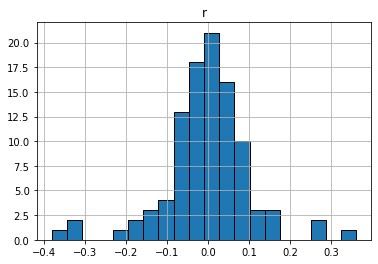

In [19]:
from matplotlib import pyplot as plt

df_ret.hist(bins=20, edgecolor='black')
plt.show()

In [45]:
from risk_utils.risk_utils import RiskAssessor

returns = df_ret['r'].to_list()
ra = RiskAssessor(np.array(returns))
ra.risk_summary()

======== RISK ASSESSMENT ========
VaR95 0.16356756809492157,    ES95 0.2876183538742304
VaR99 0.3368136416568052,     ES99 0.3814464068728292
EVT VaR99 0.3803118124603705, EVT ES99 0.381185435731757


/Users/axelnilsson/Desktop/Abacus/risk_utils/risk_utils.py:131: RuntimeWarning: invalid value encountered in log
  log_likelihood = log_likelihood + np.log(1 + params[0] / params[1] * obs)
